# Produção Energética e Sustentabilidade

### Descrição

A energia solar é uma das principais fontes de energias renováveis, desempenhando não só um papel fundamental na transição para fontes de energia limpa e renovável, mas também na promoção da sustentabilidade ambiental. Nesse contexto, além de ser crucial otimizar o uso da energia solar, a relação entre o gasto e a produção energética é essencial para permitir um planeamento eficaz do consumo energético e a integração harmoniosa de sistemas de energia solar em redes elétricas existentes.

Nesse sentido, a 6ª Edição da Competição ML @SBS/DAA consiste no desenvolvimento de modelos de Machine Learning capazes de prever, com precisão, a quantidade de energia elétrica, em kWh, gerada por painéis solares e injectada na rede eléctrica existente a cada hora do dia com base numa ampla gama de atributos, que vão desde dados meteorológicos e informações geográficas, ao histórico de gasto e produção energética.

Este é, portanto, um problema de previsão de energia com impacto significativo na eficiência energética, mas também na redução das emissões de gases com efeito estufa e na promoção da sustentabilidade. Com isso em consideração, foi colecionado um dataset que contém diversos dados referentes à produção energética de determinados painéis solares na cidade de Braga (o dataset cobre um período que vai desde setembro de 2021 até abril de 2023).

### Objetivo

O objetivo de cada grupo de trabalho passa por desenvolver o melhor modelo possível capaz de prever a quantidade de energia, em kWh, produzida por painéis solares e injectada, em redes elétricas existentes, a cada hora do dia.

O dataset utilizado nesta competição contém um conjunto de features sendo de destacar a feature Injeção na rede (kWh) . Esta feature indica, numa escala qualitativa (None, Low, Medium, High e Very_High), a quantidade de energia que se injectou na rede elétrica num determinado ponto temporal (i.e., numa determinada hora de um determinado dia). Se o valor desta feature for None, significa que não foi injectada nenhuma energia na rede (ou porque nada foi obtido dos painéis solares, ou porque toda a energia produzida pelos painéis foi consumida localmente). Um valor de Very_High implica a existência de uma quantidade muito alta de energia injectada na rede eléctrica naquele ponto temporal.

Para treino e tuning dos modelos de Machine Learning ser-vos-ão disponibilizados dois datasets com dados energéticos e dois datasets com dados meteorológicos. Tantos os datasets energéticos como os meteorológicos estão divididos por data, i.e., um dos datasets cobre o período de 2021 enquanto que o outro cobre todo o ano de 2022. Os grupos de trabalho poderão adicionar aos datasets qualquer atributo que achem relevante.

Para obtenção de scores na competição, os grupos de trabalho deverão prever, para cada registo do dataset de teste ("energia_202301-202304.csv"), a quantidade de energia que se injectou na rede elétrica num determinado ponto temporal, utilizando a escala None, Low, Medium, High e Very_High.

### Os dados

São disponibilizados dois tipos de datasets, i.e., um tipo com dados energéticos e outro tipo com dados meteorológicos. Além disso, cada tipo de dataset está dividido por data, i.e., um dos datasets cobre o período de 2021 enquanto que o outro cobre todo o ano de 2022. Em resumo, são disponibilizados quatro datasets para treino e tuning dos modelos de Machine Learning

Features dos Datasets de Energia

- **Data** - o timestamp associado ao registo, ao dia;
- **Hora** - a hora associada ao registo;
- **Normal (kWh)** - quantidade de energia eléctrica consumida, em kWh e proveniente da rede eléctrica, num período considerado normal em ciclos bi-horário diários (horas fora de vazio);
- **Horário Económico (kWh)** - quantidade de energia eléctrica consumida, em kWh e proveniente da rede eléctrica, num período considerado económico em ciclos bi-horário diários (horas de vazio);
- **Autoconsumo (kWh)** - quantidade de energia eléctrica consumida, em kWh, proveniente dos painéis solares;
- **Injeção na rede (kWh)** - quantidade de energia eléctrica injectada na rede eléctrica, em kWh, proveniente dos painéis solares.

Features dos Datasets Meteorológicos

- **dt** - o timestamp associado ao registo;
- **dt_iso** - a data associada ao registo, ao segundo;
- **city_name** - o local em causa;
- **temp** - temperatura em ºC;
- **feels_like** - sensação térmica em ºC;
- **temp_min** - temperatura mínima sentida em ºC;
- **temp_max** - temperatura máxima sentida em ºC;
- **pressure** - pressão atmosférica sentida em atm;
- **sea_level** - pressão atmosférica sentida ao nível do mar em atm;
- **grnd_level** - pressão atmosférica sentida à altitude local em atm;
- **humidity** - humidade em percentagem;
- **wind_speed** - velocidade do vento em metros por segundo;
- **rain_1h** - valor médio de precipitação;
- **clouds_all** - nível de nebulosidade em percentagem;
- **weather_description** - avaliação qualitativa do estado do tempo.


## Importar Bibliotecas

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold, GridSearchCV
from scikeras.wrappers import KerasClassifier

# Outras bibliotecas a importar mais tarde
%matplotlib inline

## Carregar os Datasets

In [215]:
energia2021 = pd.read_csv('datasets/energia_202109-202112.csv', encoding = "ISO-8859-1")
energia2022 = pd.read_csv('datasets/energia_202201-202212.csv', encoding = "ISO-8859-1")
energia2023 = pd.read_csv('datasets/energia_202301-202304.csv', encoding = "ISO-8859-1")

meteo2021 = pd.read_csv('datasets/meteo_202109-202112.csv')
meteo2022 = pd.read_csv('datasets/meteo_202201-202212.csv')
meteo2023 = pd.read_csv('datasets/meteo_202301-202304.csv')

radiation_data = pd.read_csv('datasets/radiation_data.csv')

Verificar as colunas de cada dataset

In [216]:
print(energia2021.columns)
print(energia2022.columns)
print(energia2023.columns)
print(meteo2021.columns)
print(meteo2022.columns)
print(meteo2023.columns)
print(radiation_data.columns)

Index(['Data', 'Hora', 'Normal (kWh)', 'Horário Económico (kWh)',
       'Autoconsumo (kWh)', 'Injeção na rede (kWh)'],
      dtype='object')
Index(['Data', 'Hora', 'Normal (kWh)', 'Horário Económico (kWh)',
       'Autoconsumo (kWh)', 'Injeção na rede (kWh)'],
      dtype='object')
Index(['Data', 'Hora', 'Normal (kWh)', 'Horário Económico (kWh)',
       'Autoconsumo (kWh)'],
      dtype='object')
Index(['dt', 'dt_iso', 'city_name', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidity',
       'wind_speed', 'rain_1h', 'clouds_all', 'weather_description'],
      dtype='object')
Index(['dt', 'dt_iso', 'city_name', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidity',
       'wind_speed', 'rain_1h', 'clouds_all', 'weather_description'],
      dtype='object')
Index(['dt', 'dt_iso', 'city_name', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidi

In [217]:
print(energia2021.info())
print()
print(energia2022.info())
print()
print(energia2023.info())
print()
print(meteo2021.info())
print()
print(meteo2022.info())
print()
print(meteo2023.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     2256 non-null   object 
 1   Hora                     2256 non-null   int64  
 2   Normal (kWh)             2256 non-null   float64
 3   Horário Económico (kWh)  2256 non-null   float64
 4   Autoconsumo (kWh)        2256 non-null   float64
 5   Injeção na rede (kWh)    566 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 105.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     8760 non-null   object 
 1   Hora                     8760 non-null   int64  
 2   Normal (kWh)             8760 non-null   float64
 3   Horário Eco

Conclusão: as colunas são as mesmas

Próximo passo: Concatenar os datasets

In [218]:
frames_energia = [energia2021, energia2022]
frames_meteo = [meteo2021, meteo2022]

energia = pd.concat(frames_energia)
meteo = pd.concat(frames_meteo)

meteo.rename(columns={'dt': 'Timestamp','dt_iso':'Data', 'city_name':'Nome da Cidade', 'temp':'Temperatura (ºC)', 'feels_like': 'Sensação Térmica (ºC)', 'temp_min': 'Temperatura Mínima (ºC)', 'temp_max': 'Temperatura Máxima (ºC)', 'pressure': 'Pressão Atmosférica (atm)', 'sea_level': 'Pressão atmosférica no nível do mar (atm)', 'grnd_level': 'Pressão atmosférica na altitude local (atm)', 'humidity': 'Humidade (%)', 'wind_speed': 'Velocidade do vento (m/s)', 'rain_1h': 'Valor médio de precipitação', 'clouds_all': 'Nível de nebulosidade (%)', 'weather_description': 'Avaliação qualitativa do estado do tempo'}, inplace=True)


Verificar o tamanho dos dados depois da concatenação, a presença de missing values e os tipos de dados

In [219]:
print(energia.info())
print()
print(meteo.info())

<class 'pandas.core.frame.DataFrame'>
Index: 11016 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     11016 non-null  object 
 1   Hora                     11016 non-null  int64  
 2   Normal (kWh)             11016 non-null  float64
 3   Horário Económico (kWh)  11016 non-null  float64
 4   Autoconsumo (kWh)        11016 non-null  float64
 5   Injeção na rede (kWh)    3239 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 602.4+ KB
None

<class 'pandas.core.frame.DataFrame'>
Index: 11688 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Timestamp                                    11688 non-null  int64  
 1   Data                                         11688 non-null  objec

In [220]:
meteo

,Timestamp,Data,Nome da Cidade,Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Pressão atmosférica no nível do mar (atm),Pressão atmosférica na altitude local (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo
0,1630454400,2021-09-01 00:00:00 +0000 UTC,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,83,1.18,NaN,78,broken clouds
1,1630458000,2021-09-01 01:00:00 +0000 UTC,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,83,1.46,NaN,92,overcast clouds
2,1630461600,2021-09-01 02:00:00 +0000 UTC,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,88,1.05,NaN,91,overcast clouds
3,1630465200,2021-09-01 03:00:00 +0000 UTC,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,86,0.46,0.14,94,light rain
4,1630468800,2021-09-01 04:00:00 +0000 UTC,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,89,0.93,1.26,95,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1672513200,2022-12-31 19:00:00 +0000 UTC,local,15.70,15.57,15.57,15.72,1018,NaN,NaN,86,5.56,3.58,100,moderate rain
8756,1672516800,2022-12-31 20:00:00 +0000 UTC,local,15.55,15.43,12.72,15.70,1018,NaN,NaN,87,4.47,4.20,100,heavy intensity rain
8757,1672520400,2022-12-31 21:00:00 +0000 UTC,local,13.45,13.28,12.23,13.99,1019,NaN,NaN,93,3.29,4.23,100,heavy intensity rain
8758,1672524000,2022-12-31 22:00:00 +0000 UTC,local,12.93,12.73,12.23,13.43,1019,NaN,NaN,94,1.49,3.90,100,moderate rain


In [221]:
energia

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,0.000,0.000,0.0,NaN
1,2021-09-29,1,0.000,0.000,0.0,NaN
2,2021-09-29,2,0.000,0.000,0.0,NaN
3,2021-09-29,3,0.000,0.000,0.0,NaN
4,2021-09-29,4,0.000,0.000,0.0,NaN
...,...,...,...,...,...,...
8755,2022-12-31,19,1.693,0.000,0.0,NaN
8756,2022-12-31,20,1.327,0.000,0.0,NaN
8757,2022-12-31,21,0.757,0.000,0.0,NaN
8758,2022-12-31,22,0.000,0.675,0.0,NaN


Juntar num único dataset. Precisamos de agrupar os dados metereológicos às medições de energia correspondentes.
Agrupar por Data e Hora.

In [222]:
meteo['Data'] = pd.to_datetime(meteo['Data'], format='%Y-%m-%d %H:%M:%S +0000 UTC', errors='coerce') # 2021-09-01 00:00:00 +0000 UTC
meteo.head()

,Timestamp,Data,Nome da Cidade,Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Pressão atmosférica no nível do mar (atm),Pressão atmosférica na altitude local (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo
0,1630454400,2021-09-01 00:00:00,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,83,1.18,NaN,78,broken clouds
1,1630458000,2021-09-01 01:00:00,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,83,1.46,NaN,92,overcast clouds
2,1630461600,2021-09-01 02:00:00,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,88,1.05,NaN,91,overcast clouds
3,1630465200,2021-09-01 03:00:00,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,86,0.46,0.14,94,light rain
4,1630468800,2021-09-01 04:00:00,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,89,0.93,1.26,95,moderate rain


In [223]:
radiation_data['Data'] = pd.to_datetime(radiation_data['time'], format='%Y-%m-%d %H:%M:%S +0000 UTC', errors='coerce') # 2021-09-01 00:00:00 +0000 UTC
radiation_data.drop(['time'], axis=1, inplace=True)

In [224]:

energia['Data'] = pd.to_datetime(energia.apply(lambda row: f"{row['Data']} {row['Hora']}", axis=1), format='%Y-%m-%d %H', errors='coerce') 
energia.drop('Hora', axis=1, inplace=True)
energia.head()

,Data,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29 00:00:00,0.0,0.0,0.0,NaN
1,2021-09-29 01:00:00,0.0,0.0,0.0,NaN
2,2021-09-29 02:00:00,0.0,0.0,0.0,NaN
3,2021-09-29 03:00:00,0.0,0.0,0.0,NaN
4,2021-09-29 04:00:00,0.0,0.0,0.0,NaN


### Merge aos três datasets

In [225]:
data = pd.merge(energia, meteo, how = 'left', on = 'Data')

In [226]:
data = pd.merge(data, radiation_data, how = 'left', on = 'Data')

### Verificação da coluna Timestamp e Nome da Cidade

In [227]:
data.drop(['Timestamp', 'Nome da Cidade'], axis=1, inplace=True)

Divisão da coluna Data

In [228]:
data['Year'] = data['Data'].dt.year
data['Month'] = data['Data'].dt.month
data['Day'] = data['Data'].dt.day
data['Hour'] = data['Data'].dt.hour
data['Minute'] = data['Data'].dt.minute
data['Seconds'] = data['Data'].dt.second

data.drop(['Data'], axis=1, inplace=True)

In [229]:
data.drop(['Minute', 'Seconds'], axis=1, inplace=True)

### Preparação e Transformação dos Dados

Verificar missing values

Retirar colunas 'Pressão atmosférica no nível do mar(atm)' e 'Pressão atmosférica na altitude local(atm)' (Só contém MV)

<Axes: >

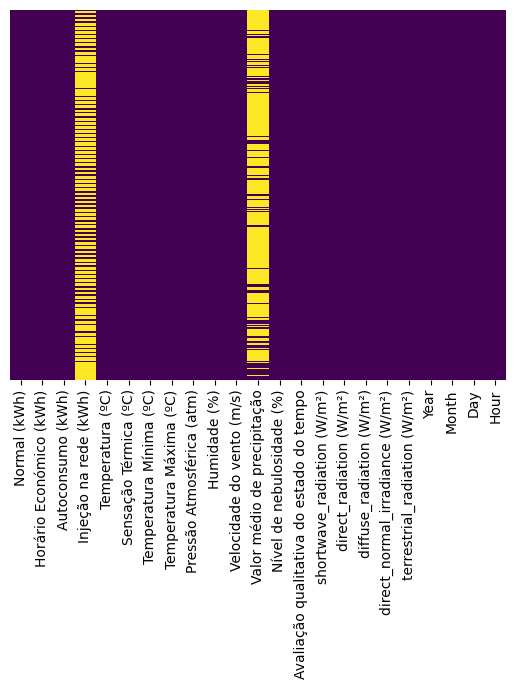

In [230]:
data.drop(['Pressão atmosférica no nível do mar (atm)', 'Pressão atmosférica na altitude local (atm)'], axis=1, inplace=True)
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Tratamento da coluna 'Valor médio de precipitação'

<Axes: >

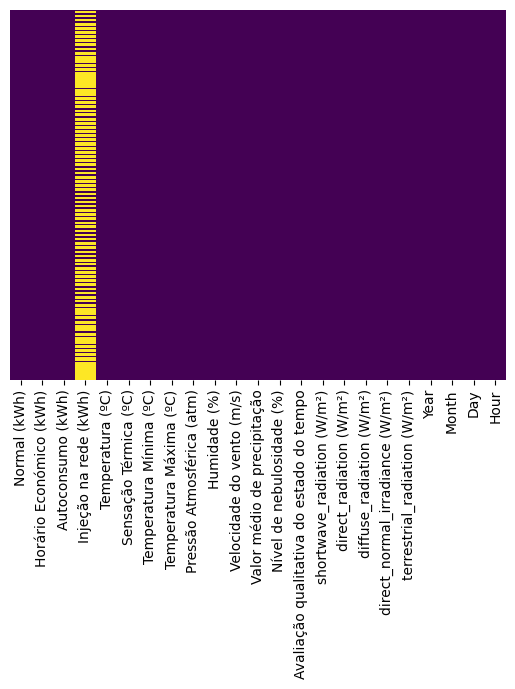

In [231]:
data['Valor médio de precipitação'] = data['Valor médio de precipitação'].fillna(0)
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Tratamento da coluna 'Injeção na rede(kWh)'

In [232]:
data['Injeção na rede (kWh)'].value_counts()

Injeção na rede (kWh)
High         1103
Medium       1098
Very High     606
Low           432
Name: count, dtype: int64

<Axes: >

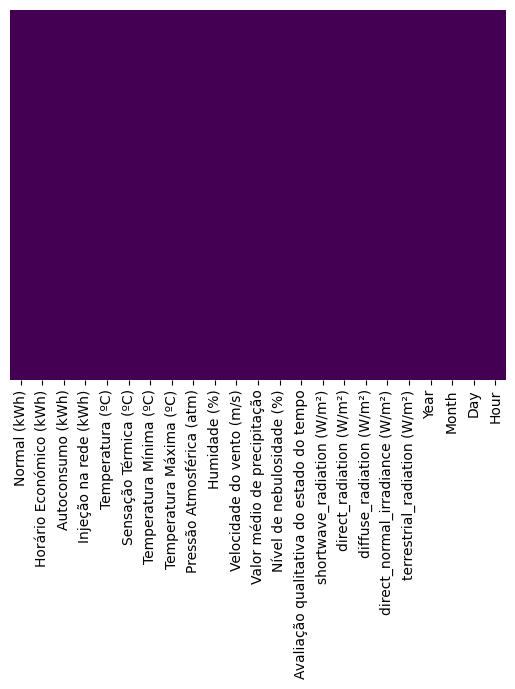

In [233]:
data['Injeção na rede (kWh)'] = data['Injeção na rede (kWh)'].fillna('None')
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [234]:
data

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Humidade (%),...,Avaliação qualitativa do estado do tempo,shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),Year,Month,Day,Hour
0,0.000,0.000,0.0,None,13.97,13.54,11.45,14.04,1027,81,...,overcast clouds,0.0,0.0,0.0,0.0,0.0,2021,9,29,0
1,0.000,0.000,0.0,None,13.48,13.02,13.43,13.90,1028,82,...,overcast clouds,0.0,0.0,0.0,0.0,0.0,2021,9,29,1
2,0.000,0.000,0.0,None,12.93,12.47,12.72,13.43,1027,84,...,overcast clouds,0.0,0.0,0.0,0.0,0.0,2021,9,29,2
3,0.000,0.000,0.0,None,12.61,12.15,10.34,12.93,1027,85,...,overcast clouds,0.0,0.0,0.0,0.0,0.0,2021,9,29,3
4,0.000,0.000,0.0,None,12.61,12.17,9.79,12.93,1027,86,...,overcast clouds,0.0,0.0,0.0,0.0,0.0,2021,9,29,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,1.693,0.000,0.0,None,15.70,15.57,15.57,15.72,1018,86,...,moderate rain,0.0,0.0,0.0,0.0,0.0,2022,12,31,19
11012,1.327,0.000,0.0,None,15.55,15.43,12.72,15.70,1018,87,...,heavy intensity rain,0.0,0.0,0.0,0.0,0.0,2022,12,31,20
11013,0.757,0.000,0.0,None,13.45,13.28,12.23,13.99,1019,93,...,heavy intensity rain,0.0,0.0,0.0,0.0,0.0,2022,12,31,21
11014,0.000,0.675,0.0,None,12.93,12.73,12.23,13.43,1019,94,...,moderate rain,0.0,0.0,0.0,0.0,0.0,2022,12,31,22


## Outliers

In [235]:
def remove_outliers(df, column_name, threshold=1.5):
    """
    Remove outliers from a DataFrame based on a specified column using IQR method.

    Args:
    - df: DataFrame containing the data
    - column_name: Name of the column to detect outliers
    - threshold: Threshold value to determine outliers based on IQR (default=1.5)

    Returns:
    - DataFrame without outliers in the specified column
    """
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - (threshold * iqr)
    upper_bound = q3 + (threshold * iqr)
    
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return filtered_df

In [236]:
mapeamento = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}

# Substituir os valores no DataFrame
data['Injeção na rede (kWh)'] = data['Injeção na rede (kWh)'].replace(mapeamento)

data['Injeção na rede (kWh)'].value_counts()

Injeção na rede (kWh)
0    7777
3    1103
2    1098
4     606
1     432
Name: count, dtype: int64

In [237]:
mapeamento = {'heavy intensity rain': 0, 'moderate rain': 1, 'light rain': 2, 'overcast clouds': 3, 'broken clouds': 4, 'scattered clouds': 5, 'few clouds': 6, 'sky is clear': 7}

# Substituir os valores no DataFrame
data['Avaliação qualitativa do estado do tempo'] = data['Avaliação qualitativa do estado do tempo'].replace(mapeamento)

In [238]:
data

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Humidade (%),...,Avaliação qualitativa do estado do tempo,shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),Year,Month,Day,Hour
0,0.000,0.000,0.0,0,13.97,13.54,11.45,14.04,1027,81,...,3,0.0,0.0,0.0,0.0,0.0,2021,9,29,0
1,0.000,0.000,0.0,0,13.48,13.02,13.43,13.90,1028,82,...,3,0.0,0.0,0.0,0.0,0.0,2021,9,29,1
2,0.000,0.000,0.0,0,12.93,12.47,12.72,13.43,1027,84,...,3,0.0,0.0,0.0,0.0,0.0,2021,9,29,2
3,0.000,0.000,0.0,0,12.61,12.15,10.34,12.93,1027,85,...,3,0.0,0.0,0.0,0.0,0.0,2021,9,29,3
4,0.000,0.000,0.0,0,12.61,12.17,9.79,12.93,1027,86,...,3,0.0,0.0,0.0,0.0,0.0,2021,9,29,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,1.693,0.000,0.0,0,15.70,15.57,15.57,15.72,1018,86,...,1,0.0,0.0,0.0,0.0,0.0,2022,12,31,19
11012,1.327,0.000,0.0,0,15.55,15.43,12.72,15.70,1018,87,...,0,0.0,0.0,0.0,0.0,0.0,2022,12,31,20
11013,0.757,0.000,0.0,0,13.45,13.28,12.23,13.99,1019,93,...,0,0.0,0.0,0.0,0.0,0.0,2022,12,31,21
11014,0.000,0.675,0.0,0,12.93,12.73,12.23,13.43,1019,94,...,1,0.0,0.0,0.0,0.0,0.0,2022,12,31,22


### Processamento do dataset de teste

In [239]:
meteo2023_2 = pd.read_csv('datasets/weather_data.csv')
meteo2023_2.rename(columns={'dt': 'Timestamp','dt_iso':'Data', 'city_name':'Nome da Cidade', 'temp':'Temperatura (ºC)', 'feels_like': 'Sensação Térmica (ºC)', 'temp_min': 'Temperatura Mínima (ºC)', 'temp_max': 'Temperatura Máxima (ºC)', 'pressure': 'Pressão Atmosférica (atm)', 'sea_level': 'Pressão atmosférica no nível do mar (atm)', 'grnd_level': 'Pressão atmosférica na altitude local (atm)', 'humidity': 'Humidade (%)', 'wind_speed': 'Velocidade do vento (m/s)', 'rain_1h': 'Valor médio de precipitação', 'clouds_all': 'Nível de nebulosidade (%)', 'weather_description': 'Avaliação qualitativa do estado do tempo'}, inplace=True)
meteo2023_2['Data'] = pd.to_datetime(meteo2023_2['Data'], format='%Y-%m-%d %H:%M:%S +0000 UTC', errors='coerce') # 2021-09-01 00:00:00 +0000 UTC

In [240]:
meteo2023.rename(columns={'dt': 'Timestamp','dt_iso':'Data', 'city_name':'Nome da Cidade', 'temp':'Temperatura (ºC)', 'feels_like': 'Sensação Térmica (ºC)', 'temp_min': 'Temperatura Mínima (ºC)', 'temp_max': 'Temperatura Máxima (ºC)', 'pressure': 'Pressão Atmosférica (atm)', 'sea_level': 'Pressão atmosférica no nível do mar (atm)', 'grnd_level': 'Pressão atmosférica na altitude local (atm)', 'humidity': 'Humidade (%)', 'wind_speed': 'Velocidade do vento (m/s)', 'rain_1h': 'Valor médio de precipitação', 'clouds_all': 'Nível de nebulosidade (%)', 'weather_description': 'Avaliação qualitativa do estado do tempo'}, inplace=True)

meteo2023['Data'] = pd.to_datetime(meteo2023['Data'], format='%Y-%m-%d %H:%M:%S +0000 UTC', errors='coerce') # 2021-09-01 00:00:00 +0000 UTC

energia2023['Data'] = pd.to_datetime(energia2023.apply(lambda row: f"{row['Data']} {row['Hora']}", axis=1), format='%Y-%m-%d %H', errors='coerce') 
energia2023.drop('Hora', axis=1, inplace=True)

In [241]:
data_test = pd.merge(energia2023, meteo2023, how='inner', on='Data')
data_test1 = pd.merge(energia2023, meteo2023_2, how='inner', on='Data')

data_test = pd.concat([data_test, data_test1])
data_test = pd.merge(data_test, radiation_data, how = 'left', on = 'Data')
data_test = data_test.reset_index(drop=True)
data_test


,Data,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Timestamp,Nome da Cidade,Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),...,Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo,shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²)
0,2023-01-01 00:00:00,0.000,0.467,0.000,1672531200,local,12.93,12.76,12.72,13.43,...,95,2.02,3.72,100,moderate rain,0.0,0.0,0.0,0.0,0.0
1,2023-01-01 01:00:00,0.000,0.577,0.000,1672534800,local,13.49,13.38,13.43,13.90,...,95,2.18,3.26,100,moderate rain,0.0,0.0,0.0,0.0,0.0
2,2023-01-01 02:00:00,0.000,0.346,0.000,1672538400,local,13.55,13.44,13.48,14.82,...,95,2.88,2.44,100,moderate rain,0.0,0.0,0.0,0.0,0.0
3,2023-01-01 03:00:00,0.000,0.270,0.000,1672542000,local,13.61,13.51,12.01,14.82,...,95,3.63,1.74,100,moderate rain,0.0,0.0,0.0,0.0,0.0
4,2023-01-01 04:00:00,0.000,0.252,0.000,1672545600,local,13.59,13.49,12.01,14.82,...,95,4.58,1.13,100,moderate rain,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2023-04-04 19:00:00,0.953,0.000,0.012,1680634800,local,290.89,290.00,290.89,290.89,...,49,1.35,NaN,100,overcast clouds,59.0,35.0,24.0,270.4,121.7
2252,2023-04-04 20:00:00,0.915,0.000,0.000,1680638400,local,288.84,287.93,288.84,288.84,...,56,1.07,NaN,100,overcast clouds,0.0,0.0,0.0,0.0,0.0
2253,2023-04-04 21:00:00,0.479,0.000,0.000,1680642000,local,287.55,286.64,287.55,287.55,...,61,1.23,NaN,90,overcast clouds,0.0,0.0,0.0,0.0,0.0
2254,2023-04-04 22:00:00,0.000,0.497,0.000,1680645600,local,286.70,285.76,286.70,286.70,...,63,1.09,NaN,82,broken clouds,0.0,0.0,0.0,0.0,0.0


In [242]:
data_test['Avaliação qualitativa do estado do tempo'].value_counts()

Avaliação qualitativa do estado do tempo
sky is clear            739
overcast clouds         489
light rain              301
broken clouds           251
scattered clouds        187
few clouds              129
clear sky                88
moderate rain            65
heavy intensity rain      7
Name: count, dtype: int64

### Remoção de Missing Values

<Axes: >

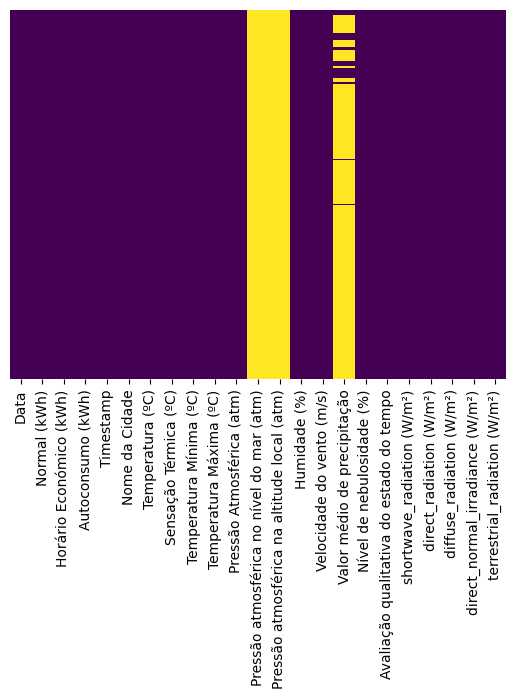

In [243]:
sns.heatmap(data_test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [244]:
print(data_test['Pressão atmosférica no nível do mar (atm)'].value_counts())
print(data_test['Pressão atmosférica na altitude local (atm)'].value_counts())
print(data_test['Nome da Cidade'].value_counts())
print(data_test['Timestamp'].value_counts())

Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
Nome da Cidade
local    2256
Name: count, dtype: int64
Timestamp
1672531200    1
1677956400    1
1677934800    1
1677938400    1
1677942000    1
             ..
1675213200    1
1675209600    1
1675206000    1
1675202400    1
1680649200    1
Name: count, Length: 2256, dtype: int64


In [245]:
data_test.drop(['Pressão atmosférica no nível do mar (atm)', 'Pressão atmosférica na altitude local (atm)','Nome da Cidade','Timestamp'], axis=1, inplace=True)

<Axes: >

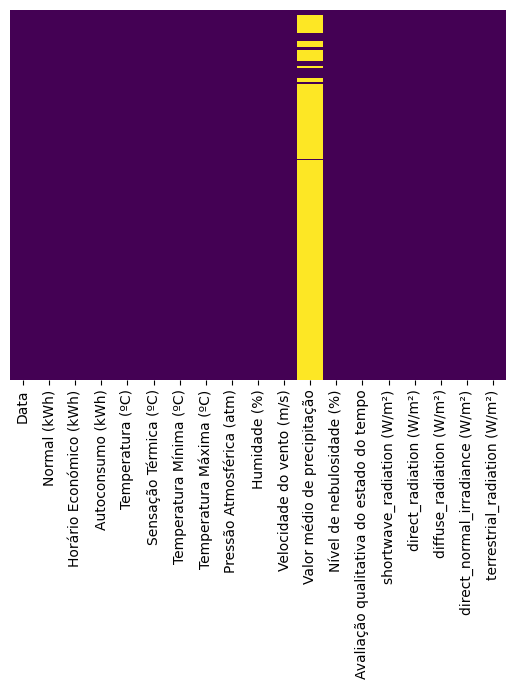

In [246]:
sns.heatmap(data_test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [247]:
data_test['Valor médio de precipitação'] = data_test['Valor médio de precipitação'].fillna(0)

In [248]:
data_test['Year'] = data_test['Data'].dt.year
data_test['Month'] = data_test['Data'].dt.month
data_test['Day'] = data_test['Data'].dt.day
data_test['Hour'] = data_test['Data'].dt.hour

data_test.drop(['Data'], axis=1, inplace=True)

In [249]:
mapeamento = {'heavy intensity rain': 0, 'moderate rain': 1, 'few clouds': 2, 'scattered clouds': 3, 'broken clouds': 4,'light rain': 5,'overcast clouds': 6,'sky is clear': 7, 'clear sky': 7}

# Substituir os valores no DataFrame
data_test['Avaliação qualitativa do estado do tempo'] = data_test['Avaliação qualitativa do estado do tempo'].replace(mapeamento)

### Modelação

### Regressão Logística

In [250]:
import time

X_train = data.drop(['Injeção na rede (kWh)', 'Velocidade do vento (m/s)', 'Sensação Térmica (ºC)', 'Temperatura Mínima (ºC)', 'Temperatura Máxima (ºC)'], axis=1)  
y_train = data['Injeção na rede (kWh)']
X_test = data_test.drop(['Velocidade do vento (m/s)', 'Sensação Térmica (ºC)', 'Temperatura Mínima (ºC)', 'Temperatura Máxima (ºC)'], axis=1) 

In [251]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Normal (kWh)                              2256 non-null   float64
 1   Horário Económico (kWh)                   2256 non-null   float64
 2   Autoconsumo (kWh)                         2256 non-null   float64
 3   Temperatura (ºC)                          2256 non-null   float64
 4   Pressão Atmosférica (atm)                 2256 non-null   int64  
 5   Humidade (%)                              2256 non-null   int64  
 6   Valor médio de precipitação               2256 non-null   float64
 7   Nível de nebulosidade (%)                 2256 non-null   int64  
 8   Avaliação qualitativa do estado do tempo  2256 non-null   int64  
 9   shortwave_radiation (W/m²)                2256 non-null   float64
 10  direct_radiation (W/m²)             

In [252]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Normal (kWh)                              11016 non-null  float64
 1   Horário Económico (kWh)                   11016 non-null  float64
 2   Autoconsumo (kWh)                         11016 non-null  float64
 3   Temperatura (ºC)                          11016 non-null  float64
 4   Pressão Atmosférica (atm)                 11016 non-null  int64  
 5   Humidade (%)                              11016 non-null  int64  
 6   Valor médio de precipitação               11016 non-null  float64
 7   Nível de nebulosidade (%)                 11016 non-null  int64  
 8   Avaliação qualitativa do estado do tempo  11016 non-null  int64  
 9   shortwave_radiation (W/m²)                11016 non-null  float64
 10  direct_radiation (W/m²)           

## Oversampling e Undersampling

In [253]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [301]:
over = SMOTE()
under = RandomUnderSampler(sampling_strategy='auto')
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
#X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [254]:
y_train.value_counts()

Injeção na rede (kWh)
0    7777
3    1103
2    1098
4     606
1     432
Name: count, dtype: int64

In [213]:
from sklearn.linear_model import LogisticRegression

### Training with newton-cg solver

In [255]:
starttime = time.process_time()

logmodel1 = LogisticRegression(random_state=2022, solver='newton-cg')
print(logmodel1)
logmodel1.fit(X_train, y_train)

endtime = time.process_time()
print(f"Time spent: {endtime - starttime} seconds")

LogisticRegression(random_state=2022, solver='newton-cg')
Time spent: 1.296875 seconds


c:\Users\mgdsb\miniconda3\envs\envNAME\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [256]:
predictions1 = logmodel1.predict(X_test)

### Training with lbfgs solver

In [167]:
starttime = time.process_time()

logmodel2 = LogisticRegression(random_state=2022, solver='lbfgs')
print(logmodel2)
logmodel2.fit(X_train,y_train)

endtime = time.process_time()
print(f"Time spent: {endtime - starttime} seconds")

LogisticRegression(random_state=2022)


Time spent: 2.762872522000009 seconds


/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [168]:
predictions2 = logmodel2.predict(X_test)

### Training with liblinear solver



In [169]:
starttime = time.process_time()

logmodel3 = LogisticRegression(random_state=2022, solver='liblinear')
print(logmodel3)
logmodel3.fit(X_train,y_train)

endtime = time.process_time()
print(f"Time spent: {endtime - starttime} seconds")

LogisticRegression(random_state=2022, solver='liblinear')


Time spent: 1.0421733600000067 seconds


In [170]:
predictions3 = logmodel3.predict(X_test)

### SVM (Support Vector Machine) with 10-Fold Cross Validation

In [171]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

df_feat = cross_val_score(SVC(random_state=2022), X_train, np.ravel(y_train), cv=10)
df_feat

array([0.70598911, 0.70598911, 0.70598911, 0.70598911, 0.70598911,
       0.70598911, 0.70663034, 0.70572207, 0.70572207, 0.70572207])

In [172]:
model = SVC(random_state=2022)

model.fit(X_train, np.ravel(y_train))

pred_svm_cv = model.predict(X_test)

### SVM (Support Vector Machine) without Cross Validation

In [173]:
model = SVC(random_state=2021)

In [174]:
model.fit(X_train, np.ravel(y_train))

SVC(random_state=2021)

In [175]:
pred_svm = model.predict(X_test)

Decision Tree

In [176]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=2021)

In [177]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2021)

In [178]:
decision_tree_predictions = dt_model.predict(X_test)

In [179]:
from sklearn.model_selection import GridSearchCV
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
estimator_dt = DecisionTreeClassifier(random_state=2021)
grid_dt = GridSearchCV(estimator_dt, param_grid, refit=True, verbose=True)

grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(estimator=DecisionTreeClassifier(random_state=2021),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]},
             verbose=True)

In [180]:
grid_dt_predictions = grid_dt.predict(X_test)

### Random Forest

In [189]:
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [190]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=2021),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

In [191]:
grid_search.fit(X_train, y_train)

/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
179 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jmartins9/miniconda3/envs/Teste/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_trai

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2021),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [192]:
best_rf = grid_search.best_estimator_

In [193]:
best_rf_predictions = best_rf.predict(X_test)

### xfgboost

In [516]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=5, seed=42,colsample_bytree=1, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=100, subsample=0.7)

In [517]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=5,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [306]:
pred_xgb = model.predict(X_test)

Grid Search

In [262]:
param_grid = {
    'max_depth': [5, 7],  # Profundidade máxima de cada árvore
    'min_child_weight': [1, 3],  # Soma mínima dos pesos das instâncias necessária em um filho
    'subsample': [0.6, 0.8],  # Fração de amostras a serem usadas para cada árvore
    'colsample_bytree': [0.6, 0.8],  # Fração de colunas a serem usadas para cada árvore
    'learning_rate': [0.01, 0.1, 0.2],  # Taxa de aprendizagem
    'n_estimators': [100, 200],  # Número de árvores de impulso
    'seed': [42]  # Semente para reprodutibilidade
}

In [263]:
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='multi:softmax', num_class=5, seed=2023),
                           param_grid=param_grid,
                           cv=3,
                           scoring='accuracy',
                           verbose=4)

In [264]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, seed=42, subsample=0.6;, score=0.835 total time=   0.2s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, seed=42, subsample=0.6;, score=0.853 total time=   0.2s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, seed=42, subsample=0.6;, score=0.883 total time=   0.2s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, seed=42, subsample=0.8;, score=0.835 total time=   0.2s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, seed=42, subsample=0.8;, score=0.853 total time=   0.2s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, seed=42, subsample=0.8

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=5,
                                     num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8],
                         'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [5, 7],
                         'min_child_weight': [1, 3], 'n_estimators': [100, 200],
                         'seed': [42], 'subsample': [0.6, 0.8]},
             scoring='accuracy', verbose=4)

In [265]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'seed': 42, 'subsample': 0.6}
Best Score: 0.8653776325344952


In [266]:
best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [267]:
y_pred_gs_xboost = best_xgb_model.predict(X_test)

### Write the results

In [268]:
import pandas as pd

def write_predictions_to_csv(index, predictions, filepath):
    df = pd.DataFrame({'RowId': index, 'Result': predictions})
    df.to_csv(filepath, index=False)

mapeamento = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
predictions = [mapeamento[prediction] for prediction in y_pred_gs_xboost]

write_predictions_to_csv(data_test.index+1, predictions, 'predictions1.csv')

### Structure the MLP

Define a model with:
- <em>ReLu</em> as activation function
- sequential topology
- three layers
- <em>MAE</em> as loss function
- <em>Adam</em> as optimizer
- learning rate of <em>0.01</em>
- <em>MAE</em> and <em>MSE</em> as metrics

In [198]:
data

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),Temperatura (ºC),Sensação Térmica (ºC),Temperatura Mínima (ºC),Temperatura Máxima (ºC),Pressão Atmosférica (atm),Humidade (%),Velocidade do vento (m/s),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo,Year,Month,Day,Hour
0,0.000,0.000,0.0,0,13.97,13.54,11.45,14.04,1027,81,1.96,0.00,87,3,2021,9,29,0
1,0.000,0.000,0.0,0,13.48,13.02,13.43,13.90,1028,82,1.83,0.00,91,3,2021,9,29,1
2,0.000,0.000,0.0,0,12.93,12.47,12.72,13.43,1027,84,1.96,0.00,93,3,2021,9,29,2
3,0.000,0.000,0.0,0,12.61,12.15,10.34,12.93,1027,85,1.85,0.00,95,3,2021,9,29,3
4,0.000,0.000,0.0,0,12.61,12.17,9.79,12.93,1027,86,1.83,0.00,93,3,2021,9,29,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,1.693,0.000,0.0,0,15.70,15.57,15.57,15.72,1018,86,5.56,3.58,100,1,2022,12,31,19
11012,1.327,0.000,0.0,0,15.55,15.43,12.72,15.70,1018,87,4.47,4.20,100,0,2022,12,31,20
11013,0.757,0.000,0.0,0,13.45,13.28,12.23,13.99,1019,93,3.29,4.23,100,0,2022,12,31,21
11014,0.000,0.675,0.0,0,12.93,12.73,12.23,13.43,1019,94,1.49,3.90,100,1,2022,12,31,22


In [192]:
from tensorflow.keras.callbacks import EarlyStopping

In [84]:
X = pd.concat([X_test, X_train])

In [85]:
X

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Temperatura (ºC),Pressão Atmosférica (atm),Humidade (%),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo,Year,Month,Day,Hour
0,0.000,0.467,0.0,12.93,1019,95,3.72,100,1,2023,1,1,0
1,0.000,0.577,0.0,13.49,1018,95,3.26,100,1,2023,1,1,1
2,0.000,0.346,0.0,13.55,1017,95,2.44,100,1,2023,1,1,2
3,0.000,0.270,0.0,13.61,1016,95,1.74,100,1,2023,1,1,3
4,0.000,0.252,0.0,13.59,1015,95,1.13,100,1,2023,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,1.693,0.000,0.0,15.70,1018,86,3.58,100,1,2022,12,31,19
11012,1.327,0.000,0.0,15.55,1018,87,4.20,100,0,2022,12,31,20
11013,0.757,0.000,0.0,13.45,1019,93,4.23,100,0,2022,12,31,21
11014,0.000,0.675,0.0,12.93,1019,94,3.90,100,1,2022,12,31,22


In [179]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [180]:
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_train = pd.DataFrame(scaler_X.transform(X_train[X_train.columns]), columns=X_train.columns)
X_test = pd.DataFrame(scaler_X.transform(X_test[X_test.columns]), columns=X_test.columns)

In [181]:
X_train

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Temperatura (ºC),Pressão Atmosférica (atm),Humidade (%),Valor médio de precipitação,Nível de nebulosidade (%),Avaliação qualitativa do estado do tempo,Year,Month,Day,Hour
0,0.000000,0.000000,0.0,0.045450,0.785714,0.773810,0.000000,0.87,0.428571,0.0,0.727273,0.933333,0.000000
1,0.000000,0.000000,0.0,0.043818,0.809524,0.785714,0.000000,0.91,0.428571,0.0,0.727273,0.933333,0.043478
2,0.000000,0.000000,0.0,0.041987,0.785714,0.809524,0.000000,0.93,0.428571,0.0,0.727273,0.933333,0.086957
3,0.000000,0.000000,0.0,0.040922,0.785714,0.821429,0.000000,0.95,0.428571,0.0,0.727273,0.933333,0.130435
4,0.000000,0.000000,0.0,0.040922,0.785714,0.833333,0.000000,0.93,0.428571,0.0,0.727273,0.933333,0.173913
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,0.500739,0.000000,0.0,0.051210,0.571429,0.833333,0.480537,1.00,0.142857,0.5,1.000000,1.000000,0.826087
11012,0.392487,0.000000,0.0,0.050711,0.571429,0.845238,0.563758,1.00,0.000000,0.5,1.000000,1.000000,0.869565
11013,0.223898,0.000000,0.0,0.043719,0.595238,0.916667,0.567785,1.00,0.000000,0.5,1.000000,1.000000,0.913043
11014,0.000000,0.096733,0.0,0.041987,0.595238,0.928571,0.523490,1.00,0.142857,0.5,1.000000,1.000000,0.956522


In [182]:
def build_model(activation='relu', learning_rate=0.001):
    model = Sequential()
    model.add(Dense(24, input_dim=X_train.shape[1], activation=activation))
    model.add(Dense(24, activation=activation))
    model.add(Dense(5, activation='softmax'))  # Output layer - 5 classes

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Nadam(learning_rate), metrics=['accuracy'])
    return model

In [183]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 24)                336       
                                                                 
 dense_10 (Dense)            (None, 24)                600       
                                                                 
 dense_11 (Dense)            (None, 5)                 125       
                                                                 
Total params: 1061 (4.14 KB)


Trainable params: 1061 (4.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [200]:
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop', 'adagrad', 'nadam'],
    #'activation': ['relu', 'sigmoid', 'tanh', 'softmax', 'elu', 'leaky_relu'],
    #learning rate
}

In [201]:
kf = KFold(n_splits=5, shuffle=True, random_state=2021)

In [190]:
model = KerasClassifier(build_fn=build_model, epochs=50, batch_size=32, verbose=0, random_state=2023)

In [191]:
history = model.fit(X_train, y_train, verbose=2)

Epoch 1/50


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


345/345 - 1s - loss: 0.8016 - accuracy: 0.7244 - 794ms/epoch - 2ms/step
Epoch 2/50
345/345 - 0s - loss: 0.5124 - accuracy: 0.7905 - 220ms/epoch - 637us/step
Epoch 3/50
345/345 - 0s - loss: 0.4695 - accuracy: 0.8027 - 215ms/epoch - 622us/step
Epoch 4/50
345/345 - 0s - loss: 0.4519 - accuracy: 0.8096 - 215ms/epoch - 624us/step
Epoch 5/50
345/345 - 0s - loss: 0.4388 - accuracy: 0.8115 - 211ms/epoch - 611us/step
Epoch 6/50
345/345 - 0s - loss: 0.4305 - accuracy: 0.8163 - 217ms/epoch - 629us/step
Epoch 7/50
345/345 - 0s - loss: 0.4220 - accuracy: 0.8208 - 216ms/epoch - 625us/step
Epoch 8/50
345/345 - 0s - loss: 0.4133 - accuracy: 0.8227 - 212ms/epoch - 615us/step
Epoch 9/50
345/345 - 0s - loss: 0.4046 - accuracy: 0.8273 - 212ms/epoch - 615us/step
Epoch 10/50
345/345 - 0s - loss: 0.3980 - accuracy: 0.8298 - 212ms/epoch - 615us/step
Epoch 11/50
345/345 - 0s - loss: 0.3906 - accuracy: 0.8321 - 209ms/epoch - 605us/step
Epoch 12/50
345/345 - 0s - loss: 0.3840 - accuracy: 0.8334 - 207ms/epoch - 6

In [203]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='accuracy',refit=True, verbose=3)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 1/5] END ....................optimizer=adam;, score=0.850 total time=  21.8s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 2/5] END ....................optimizer=adam;, score=0.867 total time=  21.6s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 3/5] END ....................optimizer=adam;, score=0.865 total time=  22.8s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 4/5] END ....................optimizer=adam;, score=0.878 total time=  22.2s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 5/5] END ....................optimizer=adam;, score=0.874 total time=  22.6s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 1/5] END .....................optimizer=sgd;, score=0.864 total time=  22.3s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 2/5] END .....................optimizer=sgd;, score=0.874 total time=  22.0s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 3/5] END .....................optimizer=sgd;, score=0.862 total time=  22.4s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 4/5] END .....................optimizer=sgd;, score=0.872 total time=  22.3s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 5/5] END .....................optimizer=sgd;, score=0.875 total time=  22.2s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 1/5] END .................optimizer=rmsprop;, score=0.863 total time=  22.3s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 2/5] END .................optimizer=rmsprop;, score=0.867 total time=  22.4s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 3/5] END .................optimizer=rmsprop;, score=0.862 total time=  22.6s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 4/5] END .................optimizer=rmsprop;, score=0.867 total time=  22.3s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 5/5] END .................optimizer=rmsprop;, score=0.881 total time=  22.2s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 1/5] END .................optimizer=adagrad;, score=0.868 total time=  23.3s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 2/5] END .................optimizer=adagrad;, score=0.872 total time=  23.0s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 3/5] END .................optimizer=adagrad;, score=0.870 total time=  22.7s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 4/5] END .................optimizer=adagrad;, score=0.864 total time=  22.5s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 5/5] END .................optimizer=adagrad;, score=0.883 total time=  21.9s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 1/5] END ...................optimizer=nadam;, score=0.872 total time=  22.0s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 2/5] END ...................optimizer=nadam;, score=0.863 total time=  21.7s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 3/5] END ...................optimizer=nadam;, score=0.869 total time=  21.7s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 4/5] END ...................optimizer=nadam;, score=0.867 total time=  21.6s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV 5/5] END ...................optimizer=nadam;, score=0.870 total time=  21.8s


c:\Users\mgdsb\miniconda3\envs\miniConda\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [204]:
best_model = grid_result.best_estimator_
best_model

KerasClassifier(
	model=None
	build_fn=<function build_model at 0x000001E5F2B38940>
	warm_start=False
	random_state=None
	optimizer=adagrad
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)

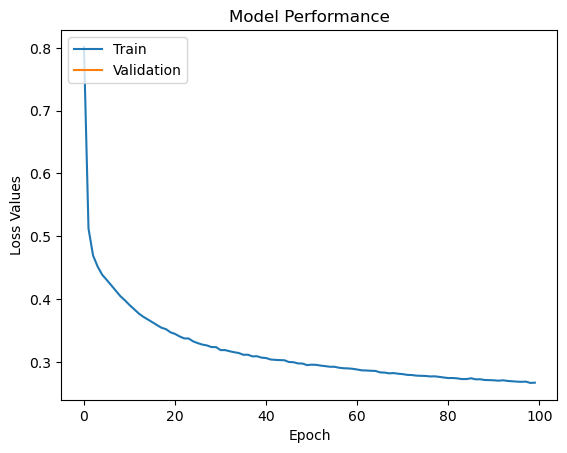

In [186]:
plt.plot(history.history_['loss'])
plt.plot(history.history_['val_loss'])
plt.title('Model Performance')
plt.ylabel('Loss Values')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [192]:
y_pred_prob = model.predict(X_test)

In [193]:
pd.DataFrame(y_pred_prob).value_counts()

0    1690
2     238
3     169
4     154
1       5
Name: count, dtype: int64

### Write the Results


In [194]:
import pandas as pd

def write_predictions_to_csv(index, predictions, filepath):
    df = pd.DataFrame({'RowId': index, 'Result': predictions})
    df.to_csv(filepath, index=False)

mapeamento = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
predictions = [mapeamento[prediction] for prediction in y_pred_prob]

write_predictions_to_csv(data_test.index+1, predictions, 'predictions2.csv')
